In [296]:
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [297]:
url = 'https://raw.githubusercontent.com/anujvyas/Diabetes-Prediction-Deployment/master/kaggle_diabetes.csv'
df = pd.read_csv(url)

In [298]:
### Lets get a quick glance at the data and some of the statistics for it
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [299]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


##### We notice that for Glucose, BloodPressure, SkinThickness, Insulin, and BMI we have min values of 0 this doesn't make sense, so we will treat 0 values as nan

##### Let's convert these values into nan first!

In [300]:
for i in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
    df[i] = df[i].replace(0,np.nan)

In [301]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,1987.000000,1910.000000,1427.000000,1044.000000,1972.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.975340,72.403665,29.341275,153.743295,32.650101,0.470930,33.090500,0.342000
std,3.306063,30.632883,12.227968,10.802278,111.273639,7.241027,0.323553,11.786423,0.474498
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.750000,27.500000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,126.000000,32.400000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [302]:
df.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

##### We can see that 0 values have been changed to nan

##### Before we take care of any of the missing values or perform EDA, lets split our data up using cross-validation. It will give us an opportunity to build a model that generalizes well to real world data

##### To see if we should use KFold or Stratified KFold, let's take a look at the value counts for the Outcome.

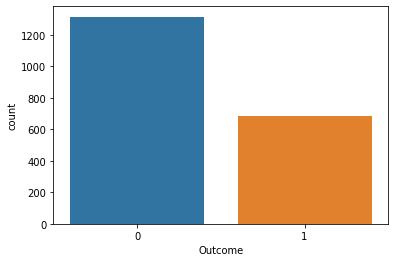

In [303]:
sns.countplot(x='Outcome', data=df);

##### We can see that the target variable is a bit imbalanced, so we should use StratifiedKFold for cross-validation

In [304]:
df['kfold'] = -1

df = df.sample(frac=1).reset_index(drop=True)

y = df['Outcome'].values

kf = StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=df,y=y)):
    df.loc[val_, 'kfold'] = fold

##### Check if we split the data properly

In [305]:
df.kfold.value_counts()

0    401
1    400
2    400
3    400
4    399
Name: kfold, dtype: int64

##### We can now try to handle the missing values

In [306]:
df.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
kfold                         0
dtype: int64

In [307]:
df.shape

(2000, 10)

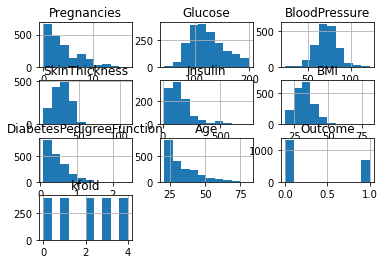

In [308]:
df.hist();

<AxesSubplot:xlabel='Outcome'>

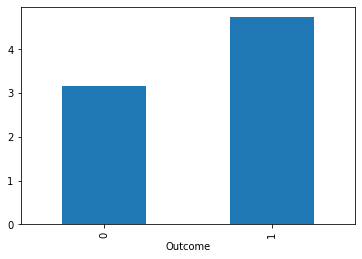

In [309]:
df.groupby('Outcome')['Pregnancies'].mean().plot.bar()

<AxesSubplot:xlabel='Outcome'>

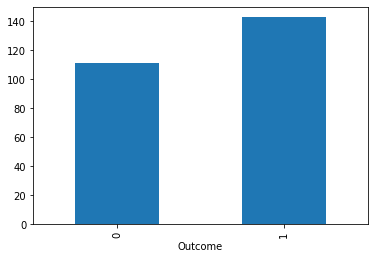

In [310]:
df.groupby('Outcome')['Glucose'].mean().plot.bar()

<AxesSubplot:xlabel='Outcome'>

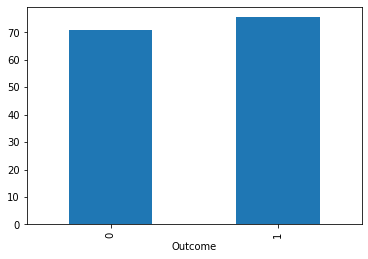

In [311]:
df.groupby('Outcome')['BloodPressure'].mean().plot.bar()

<AxesSubplot:xlabel='Outcome'>

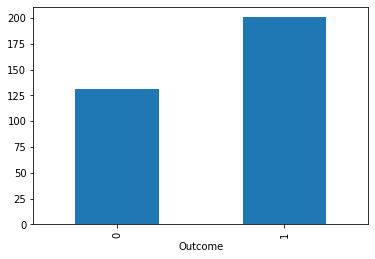

In [312]:
df.groupby('Outcome')['Insulin'].mean().plot.bar()

<AxesSubplot:xlabel='Outcome'>

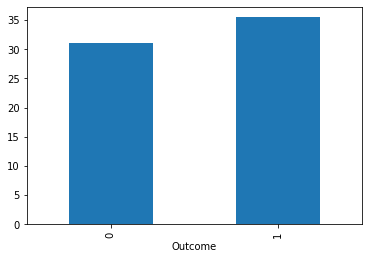

In [313]:
df.groupby('Outcome')['BMI'].mean().plot.bar()

<AxesSubplot:xlabel='Outcome'>

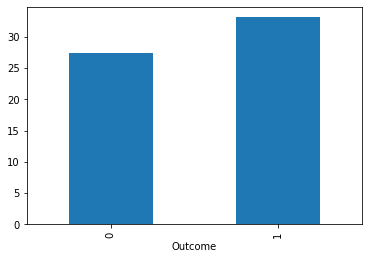

In [314]:
df.groupby('Outcome')['SkinThickness'].mean().plot.bar()

##### We can see that on average if person is recorded as having diabetes they also tend to on average have higher  Glucose, BloodPressure, SkinThickness, Insulin, and BMI


##### We should impute the nan values based on if the person is recorded to have diabetes or not

In [315]:
def median_y(feature):
    group = df[df[feature].notnull()]
    group = group.groupby('Outcome')[feature].median()
    return group
    

In [316]:
median_y('Glucose')

Outcome
0    107.0
1    141.0
Name: Glucose, dtype: float64

In [317]:
df.loc[(df['Outcome']==0) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome']==1) & (df['Glucose'].isnull()), 'Glucose'] = 141

In [318]:
median_impute('BloodPressure') 
                                

Outcome
0    70.0
1    75.0
Name: BloodPressure, dtype: float64

##### We can either use the median of 'BloodPressure' as a whole or use median based on Outcome. We might be avoid overfitting by using the median, but let's use median based on Outcome
                                 

In [319]:
df['BloodPressure'].median()

72.0

In [320]:
df.loc[(df['Outcome']==0) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome']==1) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 75

In [321]:
median_impute('Insulin')

Outcome
0    105.0
1    167.0
Name: Insulin, dtype: float64

In [322]:
df.loc[(df['Outcome']==0) & (df['Insulin'].isnull()), 'Insulin'] = 105
df.loc[(df['Outcome']==1) & (df['Insulin'].isnull()), 'Insulin'] = 167

In [323]:
df.isnull().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                 0
SkinThickness               573
Insulin                       0
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
kfold                         0
dtype: int64

In [324]:
median_impute('SkinThickness')

Outcome
0    27.0
1    32.0
Name: SkinThickness, dtype: float64

In [325]:
df.loc[(df['Outcome']==0) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome']==1) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [326]:
median_impute('BMI')

Outcome
0    30.4
1    34.3
Name: BMI, dtype: float64

In [327]:
df.loc[(df['Outcome']==0) & (df['BMI'].isnull()), 'BMI'] = 30.4
df.loc[(df['Outcome']==1) & (df['BMI'].isnull()), 'BMI'] = 34.2

In [328]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
kfold                       0
dtype: int64

In [329]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfold
0,1,100.0,72.0,12.0,70.0,25.3,0.658,28,0,0
1,7,106.0,92.0,18.0,105.0,22.7,0.235,48,0,0
2,5,139.0,80.0,35.0,160.0,31.6,0.361,25,1,0
3,3,106.0,72.0,27.0,105.0,25.8,0.207,27,0,0
4,5,144.0,82.0,26.0,285.0,32.0,0.452,58,1,0


In [330]:
df.to_csv("diab.csv")

## Feature Engineering

In [331]:
trans = df.iloc[:,:-2]

In [332]:
trans.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,100.0,72.0,12.0,70.0,25.3,0.658,28
1,7,106.0,92.0,18.0,105.0,22.7,0.235,48
2,5,139.0,80.0,35.0,160.0,31.6,0.361,25
3,3,106.0,72.0,27.0,105.0,25.8,0.207,27
4,5,144.0,82.0,26.0,285.0,32.0,0.452,58


##### Lets scale these features, since the data is has a wide range.

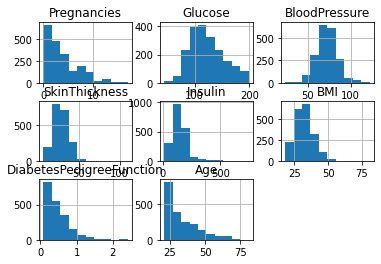

In [333]:
trans.hist(); ### Some features are Gaussian while some seem to be skewed left. 
            ### We can use both seem to see what performs better, however we could have gone with StandardScaler

In [334]:
standard = StandardScaler()
minmax = MinMaxScaler()

df_standard = trans.copy()
df_minmax = trans.copy()

standard.fit(df_standard)
minmax.fit(df_minmax)

df_standard = standard.transform(df_standard)
df_minmax = minmax.transform(df_minmax)

In [335]:
new_df_standard = pd.DataFrame(df_standard, columns=df.columns[:-2])
new_df_minmax = pd.DataFrame(df_minmax, columns=df.columns[:-2])

In [336]:
new_df_standard = pd.concat([new_df_standard,df.iloc[:,-2:]],axis=1)
new_df_minmax = pd.concat([new_df_minmax,df.iloc[:,-2:]],axis=1)

In [337]:
new_df_minmax

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfold
0,0.058824,0.361290,0.489796,0.048544,0.076712,0.113782,0.247652,0.116667,0,0
1,0.411765,0.400000,0.693878,0.106796,0.124658,0.072115,0.067037,0.450000,0,0
2,0.294118,0.612903,0.571429,0.271845,0.200000,0.214744,0.120837,0.066667,1,0
3,0.176471,0.400000,0.489796,0.194175,0.124658,0.121795,0.055081,0.100000,0,0
4,0.294118,0.645161,0.591837,0.184466,0.371233,0.221154,0.159693,0.616667,1,0
...,...,...,...,...,...,...,...,...,...,...
1995,0.000000,0.541935,0.448980,0.116505,0.227397,0.197115,0.560632,0.066667,1,4
1996,0.470588,0.987097,0.510204,0.242718,0.209589,0.123397,0.475235,0.300000,1,4
1997,0.117647,0.400000,0.326531,0.194175,0.206849,0.173077,0.148591,0.016667,0,4
1998,0.294118,0.470968,0.632653,0.223301,0.124658,0.334936,0.073868,0.350000,0,4


In [338]:
new_df_standard

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfold
0,-0.817945,-0.719333,-0.032864,-1.867829,-0.847765,-1.018262,0.578320,-0.432003,0,0
1,0.997357,-0.522972,1.639628,-1.216753,-0.431033,-1.379727,-0.729368,1.265289,0,0
2,0.392256,0.557008,0.636133,0.627963,0.223833,-0.142403,-0.339844,-0.686597,1,0
3,-0.212844,-0.522972,-0.032864,-0.240139,-0.431033,-0.948749,-0.815929,-0.516868,0,0
4,0.392256,0.720642,0.803382,-0.348651,1.712164,-0.086793,-0.058521,2.113935,1,0
...,...,...,...,...,...,...,...,...,...,...
1995,-1.120495,0.197015,-0.367363,-1.108240,0.461966,-0.295331,2.844360,-0.686597,1,4
1996,1.299907,2.455156,0.134385,0.302425,0.307180,-0.934847,2.226068,0.501507,1,4
1997,-0.515394,-0.522972,-1.370858,-0.240139,0.283366,-0.503869,-0.138899,-0.941191,0,4
1998,0.392256,-0.162979,1.137880,0.085400,-0.431033,0.900285,-0.679905,0.756101,0,4


### Model Using StandardScaler

In [355]:
def run(fold):
    new_df_standard_train = new_df_standard[new_df_standard.kfold!=fold].reset_index(drop=True)
    new_df_standard_valid = new_df_standard[new_df_standard.kfold==fold].reset_index(drop=True)
    
    x_train = new_df_standard_train.drop('Outcome',axis=1).values
    y_train = new_df_standard_train.Outcome.values
    
    x_test = new_df_standard_valid.drop('Outcome',axis=1).values
    y_test = new_df_standard_valid.Outcome.values
    
    xgb = XGBClassifier()
    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    knn = KNeighborsClassifier()
    
    xgb.fit(x_train,y_train)
    rf.fit(x_train,y_train)
    knn.fit(x_train,y_train)
    
    pred1 = xgb.predict(x_test)
    pred2 = rf.predict(x_test)
    pred3 = knn.predict(x_test)
    
    #print("Recall: ", recall_score(pred3,y_test))
    print("Recall: ", recall_score(pred2,y_test))
    
run(1)

Recall:  0.9716312056737588


### Model Using cross_val_score MinMaxScaler

In [340]:
X = new_df_minmax.drop(["Outcome","kfold"],axis=1).values
y = new_df_minmax.Outcome.values
rf = RandomForestClassifier()
xgb = XGBClassifier()
knn = KNeighborsClassifier()

rf_score = cross_val_score(estimator=rf,X=X,y=y,cv=5,scoring='recall').mean()
xgb_score = cross_val_score(estimator=xgb,X=X,y=y,cv=5,scoring='recall').mean()
knn_score = cross_val_score(estimator=knn,X=X,y=y,cv=5,scoring='recall').mean()


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

### Model Using MinMaxScaler

In [354]:
def run(fold):
    new_df_minmax_train = new_df_minmax[new_df_minmax.kfold!=fold].reset_index(drop=True)
    new_df_minmax_valid = new_df_minmax[new_df_minmax.kfold==fold].reset_index(drop=True)
    
    x_train = new_df_minmax_train.drop('Outcome',axis=1).values
    y_train = new_df_minmax_train.Outcome.values
    
    x_test = new_df_minmax_valid.drop('Outcome',axis=1).values
    y_test = new_df_minmax_valid.Outcome.values
    
    xgb = XGBClassifier()
    rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    knn = KNeighborsClassifier()
    
    xgb.fit(x_train,y_train)
    rf.fit(x_train,y_train)
    knn.fit(x_train,y_train)
    
    pred1 = xgb.predict(x_test)
    pred2 = rf.predict(x_test)
    pred3 = knn.predict(x_test)
    
    #print("Recall: ", recall_score(pred1,y_test))
    print("Recall: ", recall_score(pred2,y_test))
    #print("Recall: ", recall_score(pred3,y_test))
    
    

run(0)
run(1)
run(2)
run(3)
run(4)


Recall:  1.0
Recall:  0.9855072463768116
Recall:  0.9856115107913669
Recall:  0.9926470588235294
Recall:  0.9701492537313433


### Lets Visualize The Scores 

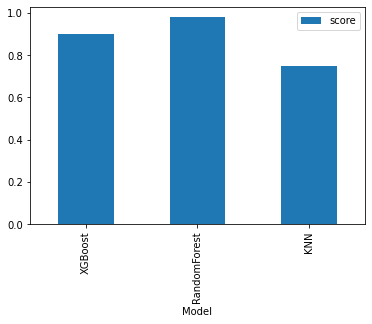

In [342]:
scores_df = pd.DataFrame({"Model": ["XGBoost", "RandomForest", "KNN"], "score": [xgb_score, rf_score, knn_score]})

scores_df.plot.bar(x="Model", y="score");

##### We can see that RandomForest performed the best and because of that we will try see if we can improve the score using Hyperparameter Tuning

## Hyperparamter Tuning

In [343]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8,10,None]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
# Criterion
criterion = ['gini','entropy']

In [344]:
params = {"n_estimators":n_estimators,
         "max_features":max_features,
         "max_depth":max_depth,
         "min_samples_split":min_samples_split,
         "min_samples_leaf":min_samples_leaf,
         "criterion":criterion}

In [349]:
random = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,scoring="recall",random_state=42,n_jobs=-1)
random1 = random.fit(X,y)
random1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [352]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=.2,random_state=42)
rf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf1.fit(X_train,Y_train)
new_pred = rf1.predict(X_test)
recall_score(new_pred,Y_test)


1.0

##### Let's see how models predict on the untransformed dataset

In [356]:
df_diab = pd.read_csv('diab.csv')

In [358]:
df_diab.drop("Unnamed: 0",axis=1,inplace=True)

In [360]:
df_diab

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfold
0,1,100.0,72.0,12.0,70.0,25.3,0.658,28,0,0
1,7,106.0,92.0,18.0,105.0,22.7,0.235,48,0,0
2,5,139.0,80.0,35.0,160.0,31.6,0.361,25,1,0
3,3,106.0,72.0,27.0,105.0,25.8,0.207,27,0,0
4,5,144.0,82.0,26.0,285.0,32.0,0.452,58,1,0
...,...,...,...,...,...,...,...,...,...,...
1995,0,128.0,68.0,19.0,180.0,30.5,1.391,25,1,4
1996,8,197.0,74.0,32.0,167.0,25.9,1.191,39,1,4
1997,2,106.0,56.0,27.0,165.0,29.0,0.426,22,0,4
1998,5,117.0,86.0,30.0,105.0,39.1,0.251,42,0,4


In [396]:
X1 = df_diab.drop(["Outcome",'kfold'],axis=1)
Y1 = df_diab.Outcome

rf2 = RandomForestClassifier()
cross_val_score(estimator=rf2, X=X1, y=Y1, cv=5, scoring = 'recall').mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

0.9824495491627309

In [397]:
random2 = RandomizedSearchCV(estimator=rf3,param_distributions=params,cv=5,scoring="recall",random_state=42,n_jobs=-1)
random3 = random2.fit(X1,Y1)

In [398]:
random3.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [400]:
rf3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

cross_val_score(estimator=rf3, X=X1, y=Y1, cv=5, scoring = 'recall').mean()

0.9882889652211249

##### We can see that hyperparameter tuning improved the model a tiny bit, so we will use this model and dataset for production

In [401]:
import pickle
pickle_out = open("rfclassifier.pkl","wb")
pickle.dump(rf3, pickle_out)
pickle_out.close()